In [254]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np

from torchvision import models

import torchio as tio

from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
import requests

In [ ]:
# elastic_transform = tio.Compose([
#     tio.RandomElasticDeformation(num_control_points=7, max_displacement=5, locked_borders=4),  # Adjust as needed
# ])

class RoofSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, processor=None, transform=None):
        """
        Args:
            image_dir (str): Path to the directory with images.
            label_dir (str): Path to the directory with corresponding labels.
            transform (callable, optional): Optional transform to be applied
                on an image and its label.
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))
        # Filter out images without corresponding labels
        self.image_filenames = [
            f for f in self.image_filenames if f in self.label_filenames
        ]
        self.label_filenames = [
            f for f in self.label_filenames if f in self.image_filenames
        ]

        if len(self.image_filenames) != len(self.label_filenames):
            raise ValueError(
                "Mismatch between number of images and labels after filtering. "
                f"Images: {len(self.image_filenames)}, Labels: {len(self.label_filenames)}"
            )

        self.transform = transform
        self.processor = processor
        # self.elastic_transform = elastic_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])

        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path).convert("L")

        image = np.array(image)
        label = np.array(label)

        # if self.elastic_transform:
        #     image = self.elastic_transform(image=image)["image"]
        #     label = self.elastic_transform(image=label)["image"]  # Apply elastic transform to label as well (if needed)

        if self.transform:
            # Apply the transform pipeline to the image and label
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']
        
        # Normalize labels to be binary (0 or 1)
        label = (label > 0).float()

        if self.processor:
          inputs = self.processor(images=image, masks=label, return_tensors="pt")
          target = label.unsqueeze(0)  # Adds channel dimension

          return {"pixel_values": inputs['pixel_values'].squeeze(), "labels": target}  # Return as dictionary



        # Add an extra dimension to match the output shape [batch_size, 1, height, width]
        label = label.unsqueeze(0)  # Adds the channel dimension

        return image, label

# Define a simple CNN architecture for segmentation
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Output layer
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc1_pool = self.pool1(enc1)
        
        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc2_pool)
        
        # Decoder
        up2 = self.up2(bottleneck)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))
        
        # Output
        out = self.out(dec1)
        return out

class ResNetUNet(nn.Module):
    def __init__(self, num_classes=1, freeze_encoder=True, dropout_rate=0.5):
        super(ResNetUNet, self).__init__()

        # Load pre-trained ResNet-18
        resnet = models.resnet18(pretrained=True)
        
        # Remove fully connected layer and average pooling
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        # Freeze layers manually
        if freeze_encoder:
            for param in resnet.conv1.parameters():
                param.requires_grad = False
            for param in resnet.layer1.parameters():  # Freeze layer1
                param.requires_grad = False
            for param in resnet.layer2.parameters():  # Freeze layer2
                param.requires_grad = False
            # for param in resnet.layer3.parameters():  # Freeze layer3
            #     param.requires_grad = False

        # Decoder with dropout
        self.up2 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout added here
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate)  # Dropout added here
        )

        self.up1 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout added here
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate)  # Dropout added here
        )

        self.final_upsample = nn.Upsample(size=(128, 128), mode='bilinear', align_corners=True)
        self.out = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        enc = self.encoder(x)
        up2 = self.up2(enc)
        dec2 = self.dec2(up2)
        up1 = self.up1(dec2)
        dec1 = self.dec1(up1)
        out = self.final_upsample(dec1)
        out = self.out(out)
        return out


class CustomSegformerModel(nn.Module):
    def __init__(self, num_classes, input_size):
        super(CustomSegformerModel, self).__init__()
        
        # Load the pretrained Segformer model
        self.model = AutoModelForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
        
        # Use the hidden size of the last encoder block
        last_hidden_size = self.model.config.hidden_sizes[-1]
        
        # Replace the classifier to output the correct number of classes
        self.model.decode_head.classifier = nn.Conv2d(
            in_channels=last_hidden_size,
            out_channels=num_classes,  # Match number of output channels to your task
            kernel_size=(1, 1)
        )
        
        # Resize input if needed
        self.input_size = input_size

    def forward(self, x):
        # Forward pass through the model
        x = self.model(x).logits
        
        # Resize logits to match the input size
        x = nn.functional.interpolate(x, size=self.input_size, mode='bilinear', align_corners=False)
        return x



In [256]:
model = CustomSegformerModel(num_classes=1, input_size=(128, 128))  # Example for 1 class (binary segmentation)

# Move to device (CPU or GPU)
model.to('cpu')  # or 'cuda' if using GPU


CustomSegformerModel(
  (model): SegformerForSemanticSegmentation(
    (segformer): SegformerModel(
      (encoder): SegformerEncoder(
        (patch_embeddings): ModuleList(
          (0): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          )
          (1): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (2): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
          )
          (3): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (

In [257]:

# Directories for images and labels
image_dir = "./images"
label_dir = "./labels"

# # Define transformations (resize and normalize images)
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize all images and labels to 128x128
#     transforms.ToTensor(),         # Convert images to PyTorch tensors
# ])



# Define the Albumentations augmentation pipeline
transform = A.Compose([
    A.Resize(128, 128),  # Resize all images and labels to 128x128
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(scale=(0.8, 1.2), shear=(-10, 10), rotate=(-30, 30), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.ElasticTransform(alpha=1.0, sigma=30, p=0.5), 
    A.RandomCrop(width=128, height=128, p=0.5),
    A.CoarseDropout(min_holes=8, max_holes=16, min_height=8, min_width=8, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize image channels
    ToTensorV2()  # Convert both images and labels to PyTorch tensors
])

# Initialize the dataset with the Albumentations transform
dataset = RoofSegmentationDataset(image_dir, label_dir, transform=transform)


# # Create dataset and dataloaders
# dataset = RoofSegmentationDataset(image_dir, label_dir, transform=transform)

TRAIN_FRACTION = 0.8
BATCH_SIZE = 8
train_size = int(TRAIN_FRACTION * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # remaining 20% for testing

# Split the dataset into training and testing subsets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for both sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# data_loader = DataLoader(dataset, batch_size=4, shuffle=True)



In [258]:
# model = ResNetUNet(num_classes=1, freeze_encoder=True)

In [259]:
train_losses = []
test_losses = []
lr_history = []
iou = []
f1 = []

In [ ]:
# model = SimpleUNet()




learning_rate = 1e-4
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# optimizer = torch.optim.Adam(
#     filter(lambda p: p.requires_grad, model.parameters()),
#     lr=learning_rate,
#     weight_decay=1e-3  # Weight decay for L2 regularization
# )

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Add weight decay


# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',          # Minimize the validation loss
#     factor=0.5,          # Reduce learning rate by half when plateau is detected
#     patience=5,          # Wait for 5 epochs with no improvement before reducing LR
#     threshold=1e-3,      # Threshold for considering a plateau in validation loss
#     verbose=True,        # Enable printing when the LR is reduced
#     min_lr=1e-6          # Set a lower bound for the learning rate
# )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)


In [261]:
# Visualization function
def visualize_results(images, labels, outputs):
    """ Visualize input images, labels, and model outputs side-by-side """
    batch_size = images.size(0)
    for i in range(batch_size):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        label = labels[i].squeeze(0).cpu().numpy()
        output = outputs[i].squeeze(0).detach().cpu().numpy()
        # print(f"output {i}", output)
        rounded_output =  output.round()


        fig, ax = plt.subplots(1, 4, figsize=(12, 4))
        ax[0].imshow(image)
        ax[0].set_title("Input Image")
        ax[0].axis("off")

        ax[1].imshow(label, cmap="gray")
        ax[1].set_title("Ground Truth Label")
        ax[1].axis("off")

        ax[2].imshow(output, cmap="gray")
        ax[2].set_title("Model Output")
        ax[2].axis("off")

        ax[3].imshow(rounded_output, cmap="gray")
        ax[3].set_title("Rounded Output")
        ax[3].axis("off")

        plt.show()

torch.Size([128, 128])


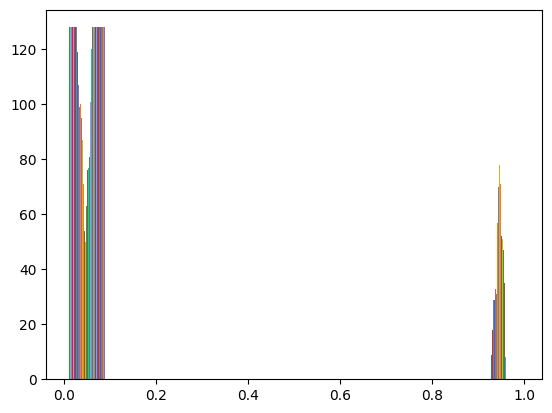

In [262]:
for images, labels in test_dataloader:
  image = images[0] #4 images/batch, 3 color channels, 128 x 128 images
  label = labels[0][0]
  print(label.shape)
  plt.hist(label)
  rounded_tensor = label.round()
  break

In [263]:
def get_loss_from_dataloader(model, dataloader, criterion, device):
    model.eval()

    # Initialize loss
    test_loss = 0.0

    # Disable gradient computation for testing
    with torch.no_grad():
        for batch in dataloader:
            # Assuming batch is a tuple (inputs, targets)
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss for the batch
            loss = criterion(outputs, targets)

            # Accumulate loss
            test_loss += loss.item()

    # Compute average loss over the entire test set
    average_loss = test_loss / len(test_dataloader)
    # print("test loss: ", average_loss)
    return average_loss

def dice_loss(pred, target, smooth=1e-6):
    # Flatten the tensors to treat them as 1D arrays
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target)

    # Dice coefficient = 2 * intersection / (union + smooth)
    dice = (2. * intersection + smooth) / (union + smooth)

    # Return 1 - dice coefficient for loss (to minimize the loss)
    return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=1.0, dice_weight=1.0):
        super(CombinedLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()  # BCE loss
        self.dice_loss = dice_loss  # Dice loss
        
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def forward(self, outputs, targets):
        # BCE Loss expects raw logits
        bce = self.bce_loss(outputs, targets)
        
        # Ensure targets are in the same shape and size as the outputs
        if outputs.shape != targets.shape:
            raise ValueError("Outputs and targets must have the same shape")

        dice = self.dice_loss(outputs.sigmoid(), targets)  # Apply sigmoid for dice calculation

        # Combine BCE and Dice loss
        combined_loss = self.bce_weight * bce + self.dice_weight * dice
        
        return combined_loss

import torch

def compute_mean_iou(model, dataloader, device='cpu', threshold=0.5):
    """
    Compute the mean IoU for a dataset using a DataLoader.
    
    Args:
    - model (torch.nn.Module): Trained segmentation model.
    - dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
    - device (str): Device to run the model ('cuda' or 'cpu').
    - threshold (float): Threshold for binarizing predictions.

    Returns:
    - mean_iou (float): Average IoU across the dataset.
    """
    model.eval()
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)  # Adjust if necessary
            predictions = (outputs > threshold).float()
            targets = targets.float()

            intersection = (predictions * targets).sum(dim=(1, 2, 3))
            union = predictions.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) - intersection
            batch_iou = (intersection + 1e-6) / (union + 1e-6)

            total_iou += batch_iou.sum().item()
            num_samples += inputs.size(0)

    mean_iou = total_iou / num_samples
    return mean_iou

def calculate_f1(predictions, targets, threshold=0.5, eps=1e-6):
    """
    Calculate F1 score (Dice Coefficient) for binary masks.
    
    Args:
    - predictions (torch.Tensor): Model predictions (logits or probabilities) of shape (N, H, W).
    - targets (torch.Tensor): Ground truth binary masks of shape (N, H, W).
    - threshold (float): Threshold for binarizing predictions.
    - eps (float): Small epsilon to avoid division by zero.

    Returns:
    - f1 (float): Mean F1 score across the batch.
    """
    # Binarize predictions
    predictions = (predictions > threshold).float()
    targets = targets.float()
    
    # Calculate intersection
    intersection = (predictions * targets).sum(dim=(1, 2))
    
    # Calculate F1 (Dice Coefficient)
    f1 = (2 * intersection + eps) / (predictions.sum(dim=(1, 2)) + targets.sum(dim=(1, 2)) + eps)
    return f1.mean().item()

def compute_mean_f1(model, dataloader, device='cpu', threshold=0.5):
    """
    Compute the mean F1 score for a dataset using a DataLoader.
    
    Args:
    - model (torch.nn.Module): Trained segmentation model.
    - dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
    - device (str): Device to run the model ('cuda' or 'cpu').
    - threshold (float): Threshold for binarizing predictions.

    Returns:
    - mean_f1 (float): Average F1 score across the dataset.
    """
    model.eval()
    total_f1 = 0.0
    num_samples = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)  # Adjust if necessary
            predictions = (outputs > threshold).float()
            targets = targets.float()

            intersection = (predictions * targets).sum(dim=(1, 2, 3))
            batch_f1 = (2 * intersection + 1e-6) / (
                predictions.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) + 1e-6
            )

            total_f1 += batch_f1.sum().item()
            num_samples += inputs.size(0)

    mean_f1 = total_f1 / num_samples
    return mean_f1



def train_unet(model, train_dataloader, test_dataloader, num_epochs=10, learning_rate=1e-4, device='cuda', train_losses=[], test_losses=[], scheduler=None, lr_history=[], iou=[], f1=[]):
    """
    Train a U-Net model with a given DataLoader.
    
    Parameters:
    - model: The U-Net model (should be a PyTorch nn.Module).
    - dataloader: DataLoader providing the training dataset.
    - num_epochs: Number of epochs to train the model.
    - learning_rate: Learning rate for the optimizer.
    - device: Device to run the model ('cuda' or 'cpu').
    """
    
    # Move model to the specified device
    model.to(device)
    
    # Define loss function and optimizer
    # criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss for segmentation tasks
    criterion = CombinedLoss()

    
    # Set the model to training mode
    model.train()

    # Iterate over the specified number of epochs
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        # Progress bar using tqdm for better visualization
        for batch_idx, (inputs, targets) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Epoch {epoch+1}/{num_epochs}'):
            # Move the inputs and targets to the device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass: Get model outputs
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backward pass: Compute gradients
            loss.backward()
            
            # Update the model weights
            optimizer.step()
            
            # Accumulate loss for the current batch
            running_loss += loss.item()
        
        # Print average loss for the epoch
        avg_loss = running_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        test_loss = get_loss_from_dataloader(model, test_dataloader, criterion, device='cpu')
        test_losses.append(test_loss)
        iou.append(compute_mean_iou(model, test_dataloader))
        f1.append(compute_mean_f1(model, test_dataloader))
        # Adjust learning rate based on the test loss
        if scheduler:
          scheduler.step(test_loss)  
        # Log learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        model.train()
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Test Loss: {test_loss:.4f}, Learning Rate: {current_lr}")
        
    print("Training finished")

In [264]:
len(dataset)


25

In [274]:
# learning_rate = 1e-4
train_unet(model, train_dataloader, test_dataloader, num_epochs=2000, learning_rate=learning_rate, device='cpu', train_losses=train_losses, test_losses=test_losses, 
          #  scheduler=scheduler, 
           lr_history=lr_history,
           iou=iou,
           f1=f1)

Epoch 1/2000: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


Epoch [1/2000], Train Loss: 0.5764, Test Loss: 0.6277, Learning Rate: 0.0001


Epoch 2/2000: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Epoch [2/2000], Train Loss: 0.5716, Test Loss: 0.5891, Learning Rate: 0.0001


Epoch 3/2000: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Epoch [3/2000], Train Loss: 0.5529, Test Loss: 0.6612, Learning Rate: 0.0001


Epoch 4/2000: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Epoch [4/2000], Train Loss: 0.5662, Test Loss: 0.5952, Learning Rate: 0.0001


Epoch 5/2000: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Epoch [5/2000], Train Loss: 0.5436, Test Loss: 0.6353, Learning Rate: 0.0001


Epoch 6/2000: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


Epoch [6/2000], Train Loss: 0.5563, Test Loss: 0.5801, Learning Rate: 0.0001


Epoch 7/2000: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Epoch [7/2000], Train Loss: 0.5551, Test Loss: 0.6600, Learning Rate: 0.0001


Epoch 8/2000: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


Epoch [8/2000], Train Loss: 0.5055, Test Loss: 0.5707, Learning Rate: 0.0001


Epoch 9/2000: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Epoch [9/2000], Train Loss: 0.5295, Test Loss: 0.6413, Learning Rate: 0.0001


Epoch 10/2000: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


Epoch [10/2000], Train Loss: 0.5153, Test Loss: 0.6690, Learning Rate: 0.0001


Epoch 11/2000: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


Epoch [11/2000], Train Loss: 0.5064, Test Loss: 0.6021, Learning Rate: 0.0001


Epoch 12/2000: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Epoch [12/2000], Train Loss: 0.5121, Test Loss: 0.6113, Learning Rate: 0.0001


Epoch 13/2000: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Epoch [13/2000], Train Loss: 0.5253, Test Loss: 0.5975, Learning Rate: 0.0001


Epoch 14/2000: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Epoch [14/2000], Train Loss: 0.5750, Test Loss: 0.5807, Learning Rate: 0.0001


Epoch 15/2000: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


Epoch [15/2000], Train Loss: 0.5275, Test Loss: 0.6434, Learning Rate: 0.0001


Epoch 16/2000: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Epoch [16/2000], Train Loss: 0.5303, Test Loss: 0.5544, Learning Rate: 0.0001


Epoch 17/2000: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Epoch [17/2000], Train Loss: 0.5663, Test Loss: 0.5729, Learning Rate: 0.0001


Epoch 18/2000: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


Epoch [18/2000], Train Loss: 0.4876, Test Loss: 0.6394, Learning Rate: 0.0001


Epoch 19/2000: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Epoch [19/2000], Train Loss: 0.5019, Test Loss: 0.5717, Learning Rate: 0.0001


Epoch 20/2000: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Epoch [20/2000], Train Loss: 0.5183, Test Loss: 0.6375, Learning Rate: 0.0001


Epoch 21/2000: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Epoch [21/2000], Train Loss: 0.4729, Test Loss: 0.5793, Learning Rate: 0.0001


Epoch 22/2000: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


Epoch [22/2000], Train Loss: 0.5800, Test Loss: 0.6173, Learning Rate: 0.0001


Epoch 23/2000: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Epoch [23/2000], Train Loss: 0.4938, Test Loss: 0.5580, Learning Rate: 0.0001


Epoch 24/2000: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Epoch [24/2000], Train Loss: 0.4847, Test Loss: 0.6516, Learning Rate: 0.0001


Epoch 25/2000: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Epoch [25/2000], Train Loss: 0.5054, Test Loss: 0.5665, Learning Rate: 0.0001


Epoch 26/2000: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Epoch [26/2000], Train Loss: 0.4881, Test Loss: 0.6033, Learning Rate: 0.0001


Epoch 27/2000: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Epoch [27/2000], Train Loss: 0.4889, Test Loss: 0.5698, Learning Rate: 0.0001


Epoch 28/2000: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


Epoch [28/2000], Train Loss: 0.4897, Test Loss: 0.4979, Learning Rate: 0.0001


Epoch 29/2000: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


Epoch [29/2000], Train Loss: 0.4761, Test Loss: 0.5667, Learning Rate: 0.0001


Epoch 30/2000: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Epoch [30/2000], Train Loss: 0.5190, Test Loss: 0.5708, Learning Rate: 0.0001


Epoch 31/2000: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


Epoch [31/2000], Train Loss: 0.4935, Test Loss: 0.5115, Learning Rate: 0.0001


Epoch 32/2000: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


Epoch [32/2000], Train Loss: 0.5136, Test Loss: 0.6350, Learning Rate: 0.0001


Epoch 33/2000: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Epoch [33/2000], Train Loss: 0.4798, Test Loss: 0.5881, Learning Rate: 0.0001


Epoch 34/2000: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Epoch [34/2000], Train Loss: 0.4741, Test Loss: 0.5592, Learning Rate: 0.0001


Epoch 35/2000: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


Epoch [35/2000], Train Loss: 0.4832, Test Loss: 0.5912, Learning Rate: 0.0001


Epoch 36/2000: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


Epoch [36/2000], Train Loss: 0.5045, Test Loss: 0.5913, Learning Rate: 0.0001


Epoch 37/2000: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


Epoch [37/2000], Train Loss: 0.4950, Test Loss: 0.6030, Learning Rate: 0.0001


Epoch 38/2000: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Epoch [38/2000], Train Loss: 0.4612, Test Loss: 0.5956, Learning Rate: 0.0001


Epoch 39/2000: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


Epoch [39/2000], Train Loss: 0.4872, Test Loss: 0.5593, Learning Rate: 0.0001


Epoch 40/2000: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Epoch [40/2000], Train Loss: 0.4783, Test Loss: 0.5470, Learning Rate: 0.0001


Epoch 41/2000: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Epoch [41/2000], Train Loss: 0.5230, Test Loss: 0.4929, Learning Rate: 0.0001


Epoch 42/2000: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Epoch [42/2000], Train Loss: 0.4815, Test Loss: 0.5947, Learning Rate: 0.0001


Epoch 43/2000: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Epoch [43/2000], Train Loss: 0.5012, Test Loss: 0.7151, Learning Rate: 0.0001


Epoch 44/2000: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


Epoch [44/2000], Train Loss: 0.4343, Test Loss: 0.5842, Learning Rate: 0.0001


Epoch 45/2000: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Epoch [45/2000], Train Loss: 0.5143, Test Loss: 0.5600, Learning Rate: 0.0001


Epoch 46/2000: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Epoch [46/2000], Train Loss: 0.4268, Test Loss: 0.5936, Learning Rate: 0.0001


Epoch 47/2000: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


Epoch [47/2000], Train Loss: 0.4539, Test Loss: 0.4932, Learning Rate: 0.0001


Epoch 48/2000: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Epoch [48/2000], Train Loss: 0.5032, Test Loss: 0.5572, Learning Rate: 0.0001


Epoch 49/2000: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Epoch [49/2000], Train Loss: 0.5006, Test Loss: 0.6526, Learning Rate: 0.0001


Epoch 50/2000: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


Epoch [50/2000], Train Loss: 0.4215, Test Loss: 0.5704, Learning Rate: 0.0001


Epoch 51/2000: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Epoch [51/2000], Train Loss: 0.4677, Test Loss: 0.5759, Learning Rate: 0.0001


Epoch 52/2000: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Epoch [52/2000], Train Loss: 0.4300, Test Loss: 0.6072, Learning Rate: 0.0001


Epoch 53/2000: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


Epoch [53/2000], Train Loss: 0.4333, Test Loss: 0.5143, Learning Rate: 0.0001


Epoch 54/2000: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


Epoch [54/2000], Train Loss: 0.4477, Test Loss: 0.6038, Learning Rate: 0.0001


Epoch 55/2000: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


Epoch [55/2000], Train Loss: 0.4367, Test Loss: 0.5930, Learning Rate: 0.0001


Epoch 56/2000: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Epoch [56/2000], Train Loss: 0.4451, Test Loss: 0.5514, Learning Rate: 0.0001


Epoch 57/2000: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Epoch [57/2000], Train Loss: 0.4070, Test Loss: 0.6006, Learning Rate: 0.0001


Epoch 58/2000: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


Epoch [58/2000], Train Loss: 0.4191, Test Loss: 0.5496, Learning Rate: 0.0001


Epoch 59/2000: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Epoch [59/2000], Train Loss: 0.4635, Test Loss: 0.5576, Learning Rate: 0.0001


Epoch 60/2000: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Epoch [60/2000], Train Loss: 0.4331, Test Loss: 0.4996, Learning Rate: 0.0001


Epoch 61/2000: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Epoch [61/2000], Train Loss: 0.4329, Test Loss: 0.5942, Learning Rate: 0.0001


Epoch 62/2000: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Epoch [62/2000], Train Loss: 0.4333, Test Loss: 0.5618, Learning Rate: 0.0001


Epoch 63/2000: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


Epoch [63/2000], Train Loss: 0.4367, Test Loss: 0.5790, Learning Rate: 0.0001


Epoch 64/2000: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Epoch [64/2000], Train Loss: 0.4116, Test Loss: 0.5888, Learning Rate: 0.0001


Epoch 65/2000: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


Epoch [65/2000], Train Loss: 0.4316, Test Loss: 0.5453, Learning Rate: 0.0001


Epoch 66/2000: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Epoch [66/2000], Train Loss: 0.3992, Test Loss: 0.5427, Learning Rate: 0.0001


Epoch 67/2000: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


Epoch [67/2000], Train Loss: 0.4057, Test Loss: 0.5001, Learning Rate: 0.0001


Epoch 68/2000: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Epoch [68/2000], Train Loss: 0.4372, Test Loss: 0.5514, Learning Rate: 0.0001


Epoch 69/2000: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Epoch [69/2000], Train Loss: 0.4063, Test Loss: 0.5229, Learning Rate: 0.0001


Epoch 70/2000: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Epoch [70/2000], Train Loss: 0.4539, Test Loss: 0.5902, Learning Rate: 0.0001


Epoch 71/2000: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


Epoch [71/2000], Train Loss: 0.4319, Test Loss: 0.5730, Learning Rate: 0.0001


Epoch 72/2000: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Epoch [72/2000], Train Loss: 0.4365, Test Loss: 0.5801, Learning Rate: 0.0001


Epoch 73/2000: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


Epoch [73/2000], Train Loss: 0.4153, Test Loss: 0.5502, Learning Rate: 0.0001


Epoch 74/2000: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Epoch [74/2000], Train Loss: 0.4862, Test Loss: 0.6082, Learning Rate: 0.0001


Epoch 75/2000: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


Epoch [75/2000], Train Loss: 0.4071, Test Loss: 0.5223, Learning Rate: 0.0001


Epoch 76/2000: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Epoch [76/2000], Train Loss: 0.3947, Test Loss: 0.6313, Learning Rate: 0.0001


Epoch 77/2000: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


Epoch [77/2000], Train Loss: 0.4124, Test Loss: 0.5718, Learning Rate: 0.0001


Epoch 78/2000: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch [78/2000], Train Loss: 0.4141, Test Loss: 0.6613, Learning Rate: 0.0001


Epoch 79/2000: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Epoch [79/2000], Train Loss: 0.4010, Test Loss: 0.5522, Learning Rate: 0.0001


Epoch 80/2000: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Epoch [80/2000], Train Loss: 0.3881, Test Loss: 0.5482, Learning Rate: 0.0001


Epoch 81/2000: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Epoch [81/2000], Train Loss: 0.4205, Test Loss: 0.5709, Learning Rate: 0.0001


Epoch 82/2000: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Epoch [82/2000], Train Loss: 0.4230, Test Loss: 0.5755, Learning Rate: 0.0001


Epoch 83/2000: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Epoch [83/2000], Train Loss: 0.4262, Test Loss: 0.6004, Learning Rate: 0.0001


Epoch 84/2000: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


Epoch [84/2000], Train Loss: 0.4064, Test Loss: 0.5198, Learning Rate: 0.0001


Epoch 85/2000: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Epoch [85/2000], Train Loss: 0.4165, Test Loss: 0.5902, Learning Rate: 0.0001


Epoch 86/2000: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


Epoch [86/2000], Train Loss: 0.4593, Test Loss: 0.5916, Learning Rate: 0.0001


Epoch 87/2000: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Epoch [87/2000], Train Loss: 0.3869, Test Loss: 0.5286, Learning Rate: 0.0001


Epoch 88/2000: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Epoch [88/2000], Train Loss: 0.4131, Test Loss: 0.7416, Learning Rate: 0.0001


Epoch 89/2000: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Epoch [89/2000], Train Loss: 0.4257, Test Loss: 0.5674, Learning Rate: 0.0001


Epoch 90/2000: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Epoch [90/2000], Train Loss: 0.4236, Test Loss: 0.5431, Learning Rate: 0.0001


Epoch 91/2000: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Epoch [91/2000], Train Loss: 0.4256, Test Loss: 0.5537, Learning Rate: 0.0001


Epoch 92/2000: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Epoch [92/2000], Train Loss: 0.3829, Test Loss: 0.5676, Learning Rate: 0.0001


Epoch 93/2000: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


Epoch [93/2000], Train Loss: 0.3818, Test Loss: 0.5372, Learning Rate: 0.0001


Epoch 94/2000: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Epoch [94/2000], Train Loss: 0.3967, Test Loss: 0.5784, Learning Rate: 0.0001


Epoch 95/2000: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


Epoch [95/2000], Train Loss: 0.3753, Test Loss: 0.5231, Learning Rate: 0.0001


Epoch 96/2000: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Epoch [96/2000], Train Loss: 0.3755, Test Loss: 0.5804, Learning Rate: 0.0001


Epoch 97/2000: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


Epoch [97/2000], Train Loss: 0.3780, Test Loss: 0.5878, Learning Rate: 0.0001


Epoch 98/2000: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch [98/2000], Train Loss: 0.4113, Test Loss: 0.6031, Learning Rate: 0.0001


Epoch 99/2000: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


Epoch [99/2000], Train Loss: 0.4134, Test Loss: 0.6121, Learning Rate: 0.0001


Epoch 100/2000: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Epoch [100/2000], Train Loss: 0.3520, Test Loss: 0.6641, Learning Rate: 0.0001


Epoch 101/2000: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


Epoch [101/2000], Train Loss: 0.4081, Test Loss: 0.5467, Learning Rate: 0.0001


Epoch 102/2000: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Epoch [102/2000], Train Loss: 0.3866, Test Loss: 0.6111, Learning Rate: 0.0001


Epoch 103/2000: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Epoch [103/2000], Train Loss: 0.4033, Test Loss: 0.5760, Learning Rate: 0.0001


Epoch 104/2000: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch [104/2000], Train Loss: 0.3736, Test Loss: 0.6036, Learning Rate: 0.0001


Epoch 105/2000: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Epoch [105/2000], Train Loss: 0.3543, Test Loss: 0.5847, Learning Rate: 0.0001


Epoch 106/2000: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Epoch [106/2000], Train Loss: 0.4116, Test Loss: 0.5020, Learning Rate: 0.0001


Epoch 107/2000: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Epoch [107/2000], Train Loss: 0.4122, Test Loss: 0.4792, Learning Rate: 0.0001


Epoch 108/2000: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Epoch [108/2000], Train Loss: 0.4305, Test Loss: 0.4978, Learning Rate: 0.0001


Epoch 109/2000: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Epoch [109/2000], Train Loss: 0.3583, Test Loss: 0.5812, Learning Rate: 0.0001


Epoch 110/2000: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Epoch [110/2000], Train Loss: 0.3807, Test Loss: 0.5974, Learning Rate: 0.0001


Epoch 111/2000: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


Epoch [111/2000], Train Loss: 0.3771, Test Loss: 0.6602, Learning Rate: 0.0001


Epoch 112/2000: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


Epoch [112/2000], Train Loss: 0.3591, Test Loss: 0.5853, Learning Rate: 0.0001


Epoch 113/2000: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Epoch [113/2000], Train Loss: 0.3754, Test Loss: 0.5309, Learning Rate: 0.0001


Epoch 114/2000: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Epoch [114/2000], Train Loss: 0.3452, Test Loss: 0.5556, Learning Rate: 0.0001


Epoch 115/2000: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Epoch [115/2000], Train Loss: 0.4626, Test Loss: 0.5940, Learning Rate: 0.0001


Epoch 116/2000: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Epoch [116/2000], Train Loss: 0.3608, Test Loss: 0.6089, Learning Rate: 0.0001


Epoch 117/2000: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Epoch [117/2000], Train Loss: 0.3489, Test Loss: 0.6811, Learning Rate: 0.0001


Epoch 118/2000: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


Epoch [118/2000], Train Loss: 0.3883, Test Loss: 0.5523, Learning Rate: 0.0001


Epoch 119/2000: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Epoch [119/2000], Train Loss: 0.4107, Test Loss: 0.6081, Learning Rate: 0.0001


Epoch 120/2000: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Epoch [120/2000], Train Loss: 0.3537, Test Loss: 0.5282, Learning Rate: 0.0001


Epoch 121/2000: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Epoch [121/2000], Train Loss: 0.3583, Test Loss: 0.6588, Learning Rate: 0.0001


Epoch 122/2000: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Epoch [122/2000], Train Loss: 0.3678, Test Loss: 0.5858, Learning Rate: 0.0001


Epoch 123/2000: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Epoch [123/2000], Train Loss: 0.3878, Test Loss: 0.5995, Learning Rate: 0.0001


Epoch 124/2000: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


Epoch [124/2000], Train Loss: 0.3447, Test Loss: 0.5662, Learning Rate: 0.0001


Epoch 125/2000: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Epoch [125/2000], Train Loss: 0.3708, Test Loss: 0.5494, Learning Rate: 0.0001


Epoch 126/2000: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Epoch [126/2000], Train Loss: 0.3564, Test Loss: 0.5658, Learning Rate: 0.0001


Epoch 127/2000: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Epoch [127/2000], Train Loss: 0.3598, Test Loss: 0.5209, Learning Rate: 0.0001


Epoch 128/2000: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


Epoch [128/2000], Train Loss: 0.3996, Test Loss: 0.5780, Learning Rate: 0.0001


Epoch 129/2000: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Epoch [129/2000], Train Loss: 0.3724, Test Loss: 0.5985, Learning Rate: 0.0001


Epoch 130/2000: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


Epoch [130/2000], Train Loss: 0.4188, Test Loss: 0.5454, Learning Rate: 0.0001


Epoch 131/2000: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Epoch [131/2000], Train Loss: 0.3482, Test Loss: 0.6178, Learning Rate: 0.0001


Epoch 132/2000:   0%|          | 0/3 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# torch.save(model, "dida_model1.pth")

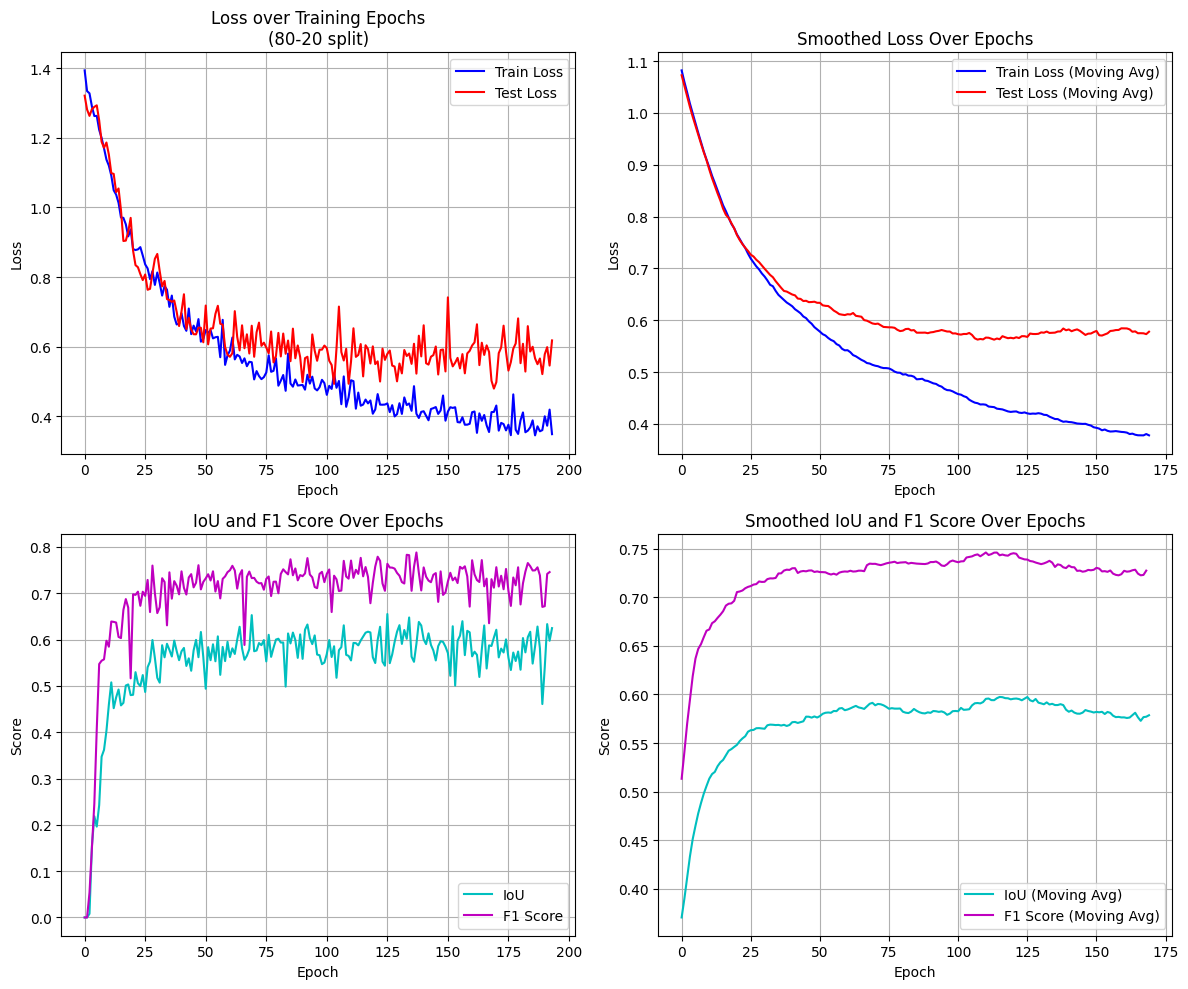

In [275]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Changed to 2 rows and 2 columns

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot the loss curves
axs[0, 0].plot(train_losses, color='b', label="Train Loss")
axs[0, 0].plot(test_losses, color='r', label="Test Loss")
axs[0, 0].set_title(f'Loss over Training Epochs\n({round(TRAIN_FRACTION*100)}-{round((1 - TRAIN_FRACTION)*100)} split)')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Plot the moving average of train and test losses
train_losses_avg = moving_average(train_losses, window_size=25)
test_losses_avg = moving_average(test_losses, window_size=25)

axs[0, 1].plot(train_losses_avg, color='b', label="Train Loss (Moving Avg)")
axs[0, 1].plot(test_losses_avg, color='r', label="Test Loss (Moving Avg)")
axs[0, 1].set_title('Smoothed Loss Over Epochs')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].legend()

# # Plot the learning rate history
# axs[1, 0].plot(lr_history, color='g', label="Learning Rate")
# axs[1, 0].set_title('Learning Rate Over Epochs')
# axs[1, 0].set_xlabel('Epoch')
# axs[1, 0].set_ylabel('Learning Rate')
# axs[1, 0].grid(True)
# axs[1, 0].set_yscale('log')
# axs[1, 0].legend()

# Plot IoU and F1 over time
axs[1, 0].plot(iou, color='c', label="IoU", linestyle='-')
axs[1, 0].plot(f1, color='m', label="F1 Score", linestyle='-')
axs[1, 0].set_title('IoU and F1 Score Over Epochs')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Score')
axs[1, 0].grid(True)
axs[1, 0].legend()

iou_avg = moving_average(iou, window_size=25)
f1_avg = moving_average(f1, window_size=25)

axs[1, 1].plot(iou_avg, color='c', label="IoU (Moving Avg)", linestyle='-')
axs[1, 1].plot(f1_avg, color='m', label="F1 Score (Moving Avg)", linestyle='-')
axs[1, 1].set_title('Smoothed IoU and F1 Score Over Epochs')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Score')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.34729..2.6399999].


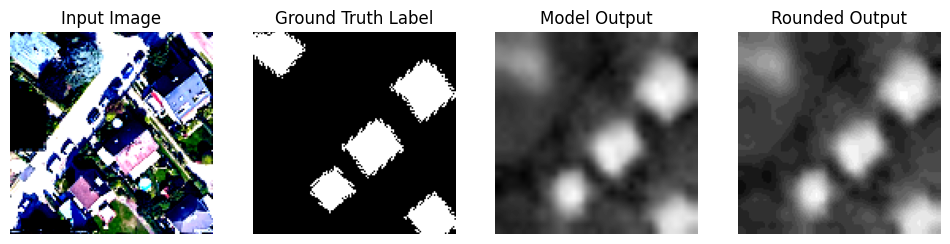

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.552854].


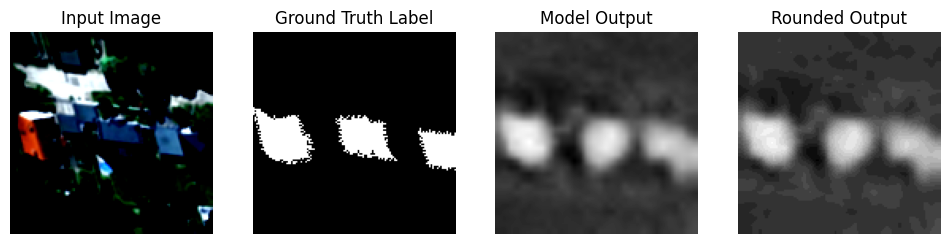

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.552854].


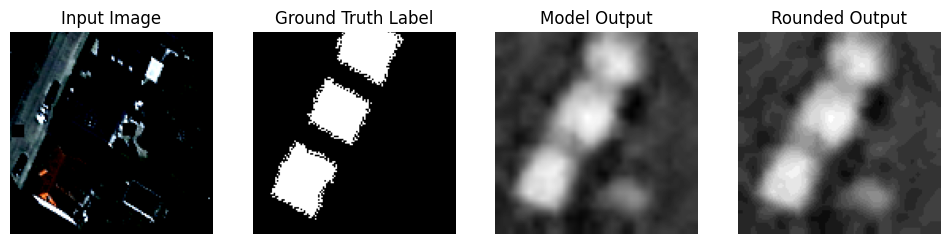

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3502396].


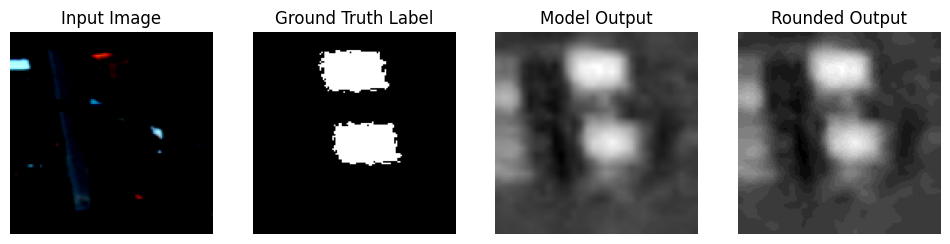

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].


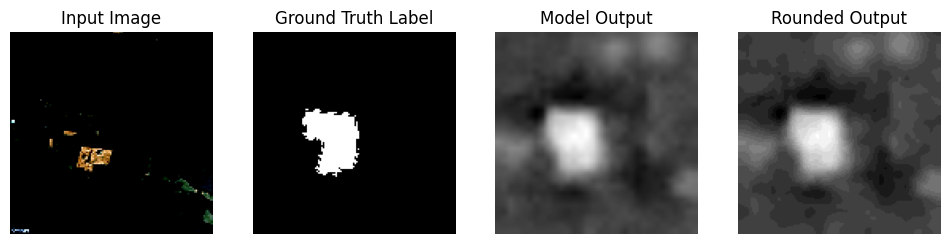

In [ ]:
# Check dataset loading and model output
for images, labels in test_dataloader:
    outputs = model(images)
    visualize_results(images, labels, outputs)
    break